In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

In [2]:
if params.feat_sel == 'auto': # automatic feature selection, based on feature importance notebook
    
    df_feat_sel = pd.read_csv(params.feat_sel_auto_csv, index_col=0, parse_dates=True)
    
elif params.feat_sel == 'man': # alternative manual feature selection, based on the features selected in the params.py
    
    df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

feat_eng_ma  feat_eng_macd  feat_eng_bb  feat_eng_rsi  \
2004-01-02 13:20:00    -0.001454       0.001532     0.029493      1.505911   
2004-01-02 13:21:00    -0.001454       0.001532     0.029493      1.505911   
2004-01-02 13:22:00    -0.001454       0.001532     0.029493      1.505911   
2004-01-02 13:23:00    -0.001454       0.001532     0.029493      1.505911   
2004-01-02 13:24:00    -0.001454       0.001532     0.029493      1.505911   
...                          ...            ...          ...           ...   
2025-06-18 20:56:00    12.076104      10.569976    -2.703249     -1.809641   
2025-06-18 20:57:00    12.360953       9.281142     2.974783     -1.535979   
2025-06-18 20:58:00    12.360953       7.476773     4.371518     -1.526312   
2025-06-18 20:59:00     9.227624      -1.287303    17.427955     -0.839051   
2025-06-18 21:00:00     8.487019      -2.318371     8.774270     -1.215607   

                     feat_eng_adx  feat_eng_obv  feat_eng_atr_div         bid  \
2004-01-02 13:20:00     -0.027654     -0.184772          0.001872    0.763480   
2004-01-02 13:21:00     -0.027654     -0.199896          0.001872    0.763463   
2004-01-02 13:22:00     -0.027654     -0.215007          0.001872    0.763446   
2004-01-02 13:23:00     -0.027654     -0.230028          0.001872    0.763430   
2004-01-02 13:24:00     -0.027654     -0.244885          0.001872    0.763413   
...                           ...           ...               ...         ...   
2025-06-18 20:56:00      0.353707      0.233838          1.374807  196.667400   
2025-06-18 20:57:00      0.453742      0.120673          1.503520  196.527500   
2025-06-18 20:58:00      0.546669      0.000243          1.203190  196.522500   
2025-06-18 20:59:00      0.240466     -0.444516          1.503520  196.092800   
2025-06-18 21:00:00      0.108968      2.909275          1.803850  196.392600   

                            ask    signal  
2004-01-02 13:20:00    0.764623  0.096829  
2004-01-02 13:21:00    0.764606  0.102961  
2004-01-02 13:22:00    0.764589  0.109480  
2004-01-02 13:23:00    0.764573  0.116411  
2004-01-02 13:24:00    0.764556  0.123782  
...                         ...       ...  
2025-06-18 20:56:00  196.962600  0.185890  
2025-06-18 20:57:00  196.822500  0.056838  
2025-06-18 20:58:00  196.817500  0.000469  
2025-06-18 20:59:00  196.387200  0.000586  
2025-06-18 21:00:00  196.687400  0.000781  

[3551120 rows x 10 columns]

In [3]:
print('executing <build_lstm_tensors>...')
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

print('executing <chronological_split>...')
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

# how many calendar-days in each split?
print("Days →",
      f"train={len(train_loader.dataset)},",
      f"val={len(val_loader.dataset)},",
      f"test={len(test_loader.dataset)}")

# how many sliding-windows in each split?
print("Windows →",
      f"train={train_loader.dataset.X.shape[0]},",
      f"val={val_loader.dataset.X.shape[0]},",
      f"test={test_loader.dataset.X.shape[0]}")

# how many batches per loader?
print("Batches →",
      f"train={len(train_loader)},",
      f"val={len(val_loader)},",
      f"test={len(test_loader)}")

executing <build_lstm_tensors>...


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

executing <chronological_split>...
executing <split_to_day_datasets>...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days → train=3808, val=783, test=809
Windows → train=1600341, val=329643, test=340589
Batches → train=119, val=783, test=809


Loading checkpoint: dfs_training/AAPL_0.2571.pth

Hyperparameters:
{'ATT_DROPOUT': 0.2,
 'ATT_HEADS': 4,
 'CLIPNORM': 0.5,
 'CLS_LOSS_WEIGHT': 0.05,
 'DROPOUT_LONG': 0.3,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 3,
 'ETA_MIN': 1e-06,
 'HUBER_BETA': 0.1,
 'INITIAL_LR': 5e-05,
 'LONG_UNITS': 64,
 'LR_EPOCHS_WARMUP': 3,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 48,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.001}


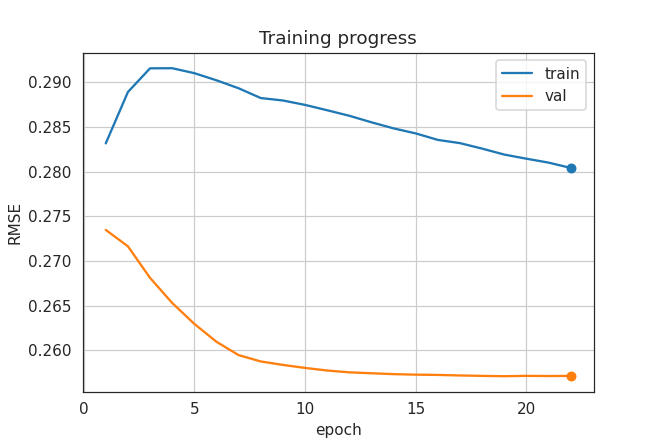


Train metrics: {'rmse': 0.28041592240333557, 'mae': 0.1954396516084671, 'r2': -0.022431612014770508, 'acc': 0.8000600934028625, 'prec': 0.4984229505062103, 'rec': 0.021239086985588074, 'f1': 0.04074205085635185, 'auroc': 0.6386535167694092}
 Val metrics: {'rmse': 0.2571147382259369, 'mae': 0.19077043235301971, 'r2': 0.07433080673217773, 'acc': 0.7977266311645508, 'prec': 0.40854281187057495, 'rec': 0.10702667385339737, 'f1': 0.1696181744337082, 'auroc': 0.6855963468551636}


DualMemoryLSTM(
  (conv): Conv1d(7, 7, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(7, 24, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(48, 32, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
  (cls_head): Linear(in_features=64, out_features=1, bias=True)
  (cls_ter): Linear(in_features=64, out_features=3, bias=True)
)

In [4]:
device = params.device

# 1) Pick the best checkpoint file
model_path = min(
    params.save_path.glob(f"{params.ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print("Loading checkpoint:", model_path)

# 2) Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# 3) Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# 4) Reinstantiate a *clean* model in CPU memory
model_best = models.DualMemoryLSTM(
    n_feats       = X.shape[-1],    
    short_units   = ckpt["hparams"]["SHORT_UNITS"],
    long_units    = ckpt["hparams"]["LONG_UNITS"],
    dropout_short = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long  = ckpt["hparams"]["DROPOUT_LONG"],
    att_heads     = ckpt["hparams"]["ATT_HEADS"],
    att_drop      = ckpt["hparams"]["ATT_DROPOUT"]
)

# 5) Load *only* the weight tensors into that fresh model
model_best.load_state_dict(ckpt["model_state_dict"])

# 6) Finally—and only now—move to GPU (or keep on CPU)
model_best.to(device)
model_best.eval()

# 7) Ready for inference!
model_best


In [5]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.37355
Test zero‐forecast baseline RMSE = 0.35626


std val: 0.2672386
std test: 0.25436968


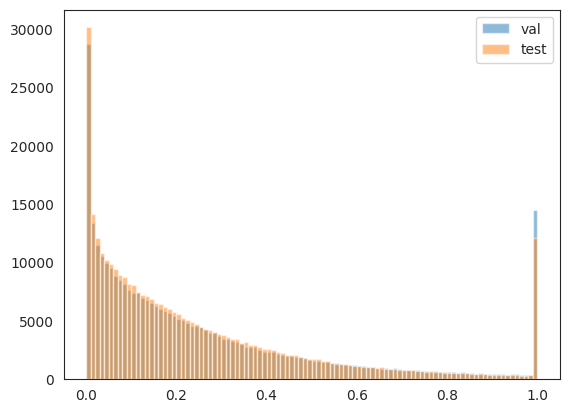

In [6]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [7]:
def make_preds_and_eval(model, loader, device, split_name: str):
    """
    Run inference over a DataLoader for a stateful CNN→BiLSTM→Attention→BiLSTM model 
    with three heads (regression, binary, ternary), compute metrics, and collect predictions.

    Functionality:
      1) Put model in eval mode and reset LSTM hidden states.
      2) Create torchmetrics objects for:
         - regression: RMSE, MAE, R2
         - binary (sig > threshold): accuracy, precision, recall, F1, AUROC
         - ternary (down/flat/up): multiclass accuracy, precision, recall, F1, AUROC
      3) For each batch in loader (no grad):
         a) Unpack padded sequences, move to device.
         b) For each sequence in the batch:
            • Slice to its true length.
            • Reset or carry LSTM states on day rollover.
            • Forward pass → raw_reg, raw_bin, raw_ter logits.
            • Sigmoid‐activate the regression head so pr ∈ [0,1].
            • Sigmoid/softmax the other heads for probabilities.
            • Update all metrics on the unpadded windows.
            • Append pr to the predictions list.
      4) After looping, compute final metric values.
      5) Print metrics in the format:
         R: … | B: … | T: …
      6) Return (metrics_dict, concatenated_predictions).

    Returns:
      metrics_dict: Dict[str, float] of computed metrics.
      all_preds:    numpy array of all sigmoid’d regression outputs.
    """
    # 1) Prepare model
    model.to(device).eval()
    model.h_short = model.h_long = None

    # 2) Instantiate metrics on target device
    thr        = 0.5
    rmse_m     = torchmetrics.MeanSquaredError(squared=False).to(device)
    mae_m      = torchmetrics.MeanAbsoluteError().to(device)
    r2_m       = torchmetrics.R2Score().to(device)

    acc_m      = torchmetrics.classification.BinaryAccuracy(threshold=thr).to(device)
    prec_m     = torchmetrics.classification.BinaryPrecision(threshold=thr).to(device)
    rec_m      = torchmetrics.classification.BinaryRecall(threshold=thr).to(device)
    f1_m       = torchmetrics.classification.BinaryF1Score(threshold=thr).to(device)
    auc_m      = torchmetrics.classification.BinaryAUROC().to(device)

    ter_acc_m  = torchmetrics.classification.MulticlassAccuracy(num_classes=3).to(device)
    ter_prec_m = torchmetrics.classification.MulticlassPrecision(num_classes=3, average="macro").to(device)
    ter_rec_m  = torchmetrics.classification.MulticlassRecall(num_classes=3, average="macro").to(device)
    ter_f1_m   = torchmetrics.classification.MulticlassF1Score(num_classes=3, average="macro").to(device)
    ter_auc_m  = torchmetrics.classification.MulticlassAUROC(num_classes=3, average="macro").to(device)

    # Reset all metrics
    for m in (
        rmse_m, mae_m, r2_m,
        acc_m, prec_m, rec_m, f1_m, auc_m,
        ter_acc_m, ter_prec_m, ter_rec_m, ter_f1_m, ter_auc_m
    ):
        m.reset()

    all_preds = []
    prev_day  = None

    # 3) Loop over batches without gradient tracking
    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # Unpack batch (11‐tuple or 8‐tuple)
            if len(batch) == 11:
                xb, y_reg, y_bin, y_ret, y_ter, rc, rb, ra, wd, ts_list, lengths = batch
            else:
                xb, y_reg, y_bin, y_ret, y_ter, wd, ts_list, lengths = batch

            # Move to device
            xb    = xb.to(device, non_blocking=True)
            y_reg = y_reg.to(device, non_blocking=True)
            y_bin = y_bin.to(device, non_blocking=True)
            y_ret = y_ret.to(device, non_blocking=True)
            y_ter = y_ter.to(device, non_blocking=True)
            wd    = wd.to(device, non_blocking=True)

            B = xb.size(0)
            for i in range(B):
                W_true = lengths[i]
                day_id = int(wd[i].item())

                # reset or carry LSTM states on new day
                model.reset_short()
                if prev_day is not None and day_id < prev_day:
                    model.reset_long()
                prev_day = day_id

                # Slice sequences to true length
                x_day = xb[i, :W_true]
                y_day = y_reg[i, :W_true].view(-1)
                bin_t = y_bin[i, :W_true].view(-1)
                ter_t = y_ter[i, :W_true].view(-1)

                # Forward pass to get raw logits
                raw_reg, raw_bin, raw_ter = model(x_day)

                # ← FIX: apply sigmoid so regression outputs ∈ [0,1]
                pr = torch.sigmoid(raw_reg[..., -1, 0])    # (W_true,)

                # Binary & ternary probabilities
                pb = torch.sigmoid(raw_bin[..., -1, 0])     # (W_true,)
                pt = torch.softmax(raw_ter[..., -1, :], dim=-1)  # (W_true,3)

                # Update metrics
                rmse_m.update(pr, y_day)
                mae_m .update(pr, y_day)
                r2_m  .update(pr, y_day)

                acc_m .update(pb,  bin_t)
                prec_m.update(pb,  bin_t)
                rec_m .update(pb,  bin_t)
                f1_m  .update(pb,  bin_t)
                auc_m .update(pb,  bin_t)

                ter_acc_m .update(pt, ter_t)
                ter_prec_m.update(pt, ter_t)
                ter_rec_m .update(pt, ter_t)
                ter_f1_m  .update(pt, ter_t)
                ter_auc_m .update(pt, ter_t)

                # Collect predictions
                all_preds.append(pr.cpu().numpy())

    # 4) Compute and gather final metrics
    metrics = {
        "rmse":  rmse_m.compute().item(),
        "mae":   mae_m.compute().item(),
        "r2":    r2_m.compute().item(),
        "acc":   acc_m.compute().item(),
        "prec":  prec_m.compute().item(),
        "rec":   rec_m.compute().item(),
        "f1":    f1_m.compute().item(),
        "auroc": auc_m.compute().item(),
        "t_acc":  ter_acc_m.compute().item(),
        "t_prec": ter_prec_m.compute().item(),
        "t_rec":  ter_rec_m.compute().item(),
        "t_f1":   ter_f1_m.compute().item(),
        "t_auc":  ter_auc_m.compute().item()
    }

    # 5) Print in the R | B | T format
    print(
        f"{split_name}→ "
        f'"R": RMSE={metrics["rmse"]:.5f} MAE={metrics["mae"]:.5f} R2={metrics["r2"]:.4f} | '
        f'"B": Acc={metrics["acc"]:.4f} Prec={metrics["prec"]:.4f} Rec={metrics["rec"]:.4f} '
           f'F1={metrics["f1"]:.4f} AUROC={metrics["auroc"]:.4f} | '
        f'"T": Acc={metrics["t_acc"]:.4f} Prec={metrics["t_prec"]:.4f} Rec={metrics["t_rec"]:.4f} '
           f'F1={metrics["t_f1"]:.4f} AUROC={metrics["t_auc"]:.4f}'
    )

    # Return metrics dict and concatenated predictions
    return metrics, np.concatenate(all_preds, axis=0)


In [8]:
# Run evaluation on all three splits
train_metrics, train_preds = make_preds_and_eval(
    model_best, train_loader, device, split_name="TRAIN"
)
val_metrics, val_preds     = make_preds_and_eval(
    model_best, val_loader,   device, split_name="VALID"
)
test_metrics, test_preds   = make_preds_and_eval(
    model_best, test_loader,  device, split_name="TEST"
)

print("\nPredictions lengths:")
print(f"  Train: {len(train_preds)}")
print(f"  Valid: {len(val_preds)}")
print(f"  Test : {len(test_preds)}")


TRAIN:   0%|          | 0/119 [00:00<?, ?batch/s]

TRAIN→ "R": RMSE=0.30474 MAE=0.20218 R2=-0.2075 | "B": Acc=0.8061 Prec=0.5818 Rec=0.0043 F1=0.0086 AUROC=0.6732 | "T": Acc=0.5322 Prec=0.3336 Rec=0.5322 F1=0.2339 AUROC=0.7169


VALID:   0%|          | 0/783 [00:00<?, ?batch/s]

VALID→ "R": RMSE=0.25711 MAE=0.19077 R2=0.0743 | "B": Acc=0.8029 Prec=0.4016 Rec=0.1085 F1=0.1709 AUROC=0.6872 | "T": Acc=0.4298 Prec=0.3334 Rec=0.4298 F1=0.0842 AUROC=0.5870


TEST:   0%|          | 0/809 [00:00<?, ?batch/s]

TEST→ "R": RMSE=0.25430 MAE=0.20567 R2=0.0005 | "B": Acc=0.7829 Prec=0.2872 Rec=0.1826 F1=0.2233 AUROC=0.6305 | "T": Acc=0.2137 Prec=0.3334 Rec=0.2137 F1=0.0144 AUROC=0.4948

Predictions lengths:
  Train: 1600341
  Valid: 329643
  Test : 340589


In [9]:
# Train metrics: {'rmse': 0.2564132809638977, 'mae': 0.18174372613430023, 'r2': 0.1271190643310547, 'acc': 0.827835202217102, 'prec': 0.5648394227027893, 'rec': 0.123975969851017, 'f1': 0.20332448184490204, 'auroc': 0.7604720592498779}
#  Val metrics: {'rmse': 0.2612327039241791, 'mae': 0.1788761168718338, 'r2': 0.02456080913543701, 'acc': 0.8381752967834473, 'prec': 0.6197602152824402, 'rec': 0.11496271193027496, 'f1': 0.19394879043102264, 'auroc': 0.776253879070282}

In [10]:
def add_preds_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds:   np.ndarray,
    test_preds:  np.ndarray,
    end_times_tr:  np.ndarray,   # timestamps for training-window ends
    end_times_val: np.ndarray,   # timestamps for validation-window ends
    end_times_te:  np.ndarray    # timestamps for test-window ends
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Copy minute‐bar DataFrame and append:
         • 'pred_signal' (continuous model output at each window end)
         • 'close_mid'    (mid‐price from bid & ask for sim price)
    2) Build three timestamp→prediction Series for train/val/test.
    3) Stamp each Series into df2['pred_signal'], warning on missing indices.
    4) Split df2 into:
         • df_trainval: rows with train or val window‐end indices
         • df_test:     rows with test window‐end indices
       and drop any NaNs in 'pred_signal'.
    5) Return (df_trainval, df_test).
    """
    # 1) Copy & initialize pred_signal + mid‐price
    df2 = df.copy()
    df2["pred_signal"] = np.nan
    # mid‐price for trade simulation
    df2["close_mid"] = (df2["bid"] + df2["ask"]) / 2

    # 2) Build prediction Series with DatetimeIndex
    s_tr  = pd.Series(train_preds, index=pd.DatetimeIndex(end_times_tr))
    s_val = pd.Series(val_preds,   index=pd.DatetimeIndex(end_times_val))
    s_te  = pd.Series(test_preds,  index=pd.DatetimeIndex(end_times_te))

    # internal helper to stamp preds into df2
    def _stamp(series: pd.Series, label: str):
        missing = series.index.difference(df2.index)
        if not missing.empty:
            print(f"⚠️ {label}: {len(missing)} timestamps not found in DataFrame")
        valid = series.index.intersection(df2.index)
        df2.loc[valid, "pred_signal"] = series.loc[valid].values

    # 3) Stamp train, val, test predictions
    _stamp(s_tr,  "Train")
    _stamp(s_val, "Val")
    _stamp(s_te,  "Test")
    print(f"✅ Stamped {len(s_tr)} Train, {len(s_val)} Val, {len(s_te)} Test predictions")

    # 4) Split and drop NaNs in pred_signal
    idx_trval = s_tr.index.union(s_val.index).intersection(df2.index)
    idx_te    = s_te.index.intersection(df2.index)

    df_trainval = df2.loc[idx_trval].dropna(subset=["pred_signal"])
    df_test     = df2.loc[idx_te].dropna(subset=["pred_signal"])

    print(f"➡️  train+val: {len(df_trainval)} rows, test: {len(df_test)} rows")
    return df_trainval, df_test


In [11]:
# 1) Stamp predictions and mid‐price, then split into train+val & test
df_trainval, df_test = add_preds_and_split(
    df            = df_feat_sel,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

# 2) Persist CSVs
print("Saving test CSV…")
df_test.to_csv(params.test_csv)
print("Saving train+val CSV…")
df_trainval.to_csv(params.trainval_csv)

✅ Stamped 1600341 Train, 329643 Val, 340589 Test predictions
➡️  train+val: 1929984 rows, test: 340589 rows
Saving test CSV…
Saving train+val CSV…


In [12]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

count      mean       std       min       25%       50%  \
signal       340589.0  0.249432  0.254370  0.000000  0.057660  0.166886   
pred_signal  340589.0  0.301200  0.085647  0.071345  0.241898  0.297997   

                  75%       max     range  pearson_r_with_other  
signal       0.353849  1.000000  1.000000              0.230635  
pred_signal  0.356280  0.660213  0.588868              0.230635

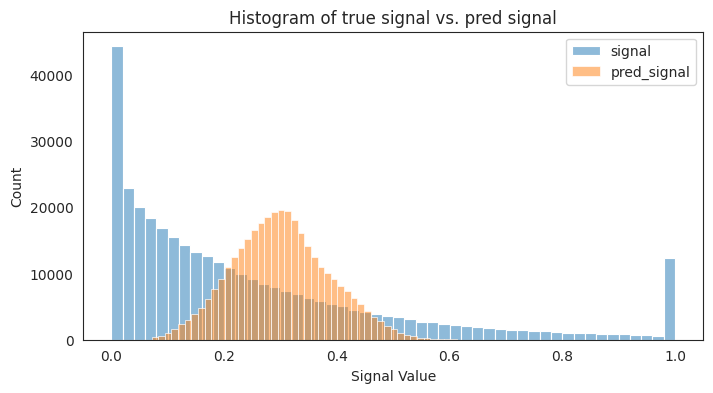

In [13]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

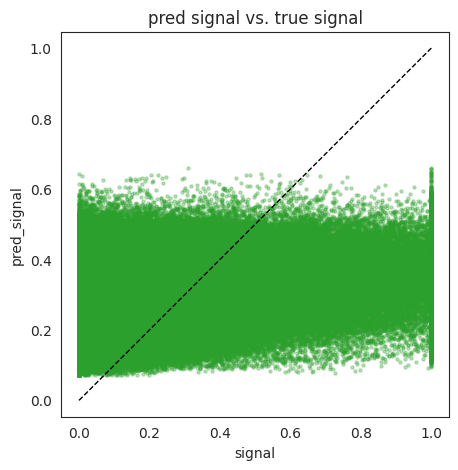

In [14]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

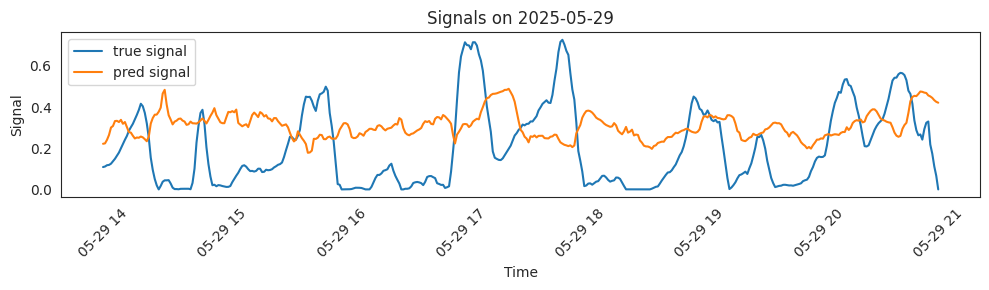

In [15]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-15]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal'], label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

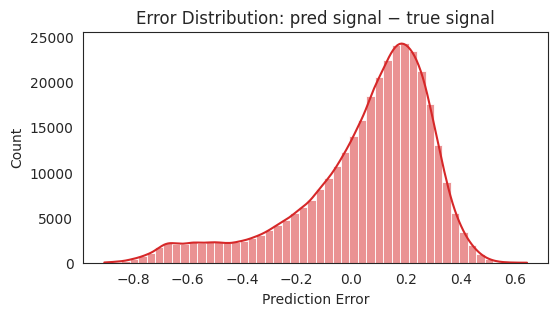

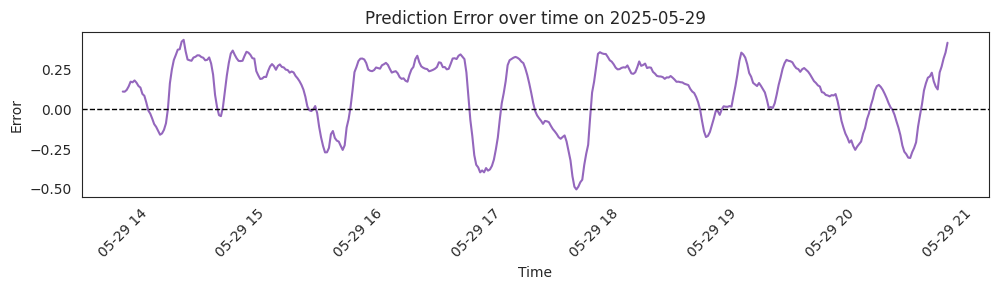

In [16]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.

# Simulate per‐day to avoid cross‐midnight state carry‐over
sim_results = {}
groups     = list(df_test.groupby(df_test.index.normalize()))
print(f"Processing {len(groups)} days of predictions…")

for day, df_day in tqdm(groups, desc="Generate+Simulate"):
    # a) Generate discrete actions from the continuous signal
    df_actions = trades.generate_trade_actions(
        df                = df_day,
        col_signal        = "pred_signal", # name for the signal column to use
        col_action        = "pred_action", # name for the trade-action column to add
        buy_threshold     = params.pred_threshold_tick,
        trailing_stop_pct = params.trailing_stop_pred_tick,
        sess_start        = params.sess_start,
        col_close         = "close_mid"    # name of the column to use for price
    )

    # b) Run the backtest on this single‐day DataFrame
    single_result = trades.simulate_trading(
        results_by_day_sign = {day: (df_actions, [])},
        col_action          = "pred_action",
        sess_start          = params.sess_start,
        sess_end            = params.sess_end,
        ticker              = params.ticker
    )
    sim_results.update(single_result)

# final: sim_results holds each day → (df_sim, trades, stats)


Processing 809 days of predictions…


Generate+Simulate:   0%|          | 0/809 [00:00<?, ?it/s]


Plotting days in 2023-09:



=== Performance for 2023-09-01 00:00:00 ===
Buy & Hold Return ($): -0.449
Strategy Return ($): -2.408
Trades Returns ($): [-1.228, -0.296, 0.081, -0.379, -0.138, -0.253, -0.193]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-05 00:00:00 ===
Buy & Hold Return ($): 1.167
Strategy Return ($): -0.135
Trades Returns ($): [1.027, -0.324, -0.398, -0.389, -0.049]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-06 00:00:00 ===
Buy & Hold Return ($): -5.819
Strategy Return ($): -6.387
Trades Returns ($): [-4.39, -0.616, -0.376, -1.006]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-07 00:00:00 ===
Buy & Hold Return ($): 2.935
Strategy Return ($): 2.935
Trades Returns ($): [2.935]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-08 00:00:00 ===
Buy & Hold Return ($): -0.968
Strategy Return ($): -1.779
Trades Returns ($): [0.227, 0.122, -0.404, -0.144, -0.228, -1.344, -0.007]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-11 00:00:00 ===
Buy & Hold Return ($): -1.007
Strategy Return ($): -3.597
Trades Returns ($): [-1.966, -0.327, -0.427, 0.552, -0.454, -0.374, 0.081, -0.349, -0.329]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-12 00:00:00 ===
Buy & Hold Return ($): -3.195
Strategy Return ($): -3.339
Trades Returns ($): [-2.85, -1.274, 0.787]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-13 00:00:00 ===
Buy & Hold Return ($): -2.836
Strategy Return ($): -3.288
Trades Returns ($): [-1.705, -0.342, -0.387, -0.852]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-14 00:00:00 ===
Buy & Hold Return ($): 1.605
Strategy Return ($): 0.703
Trades Returns ($): [1.315, 0.286, -0.403, -0.503, 0.007]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-15 00:00:00 ===
Buy & Hold Return ($): -1.198
Strategy Return ($): -3.041
Trades Returns ($): [-1.538, -0.192, -0.28, -0.403, -0.522, -0.173, -0.372, 0.438]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-18 00:00:00 ===
Buy & Hold Return ($): 0.72
Strategy Return ($): -0.955
Trades Returns ($): [1.084, 0.093, -0.323, -0.303, -0.533, -0.726, -0.246]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-19 00:00:00 ===
Buy & Hold Return ($): 1.127
Strategy Return ($): -0.715
Trades Returns ($): [-0.386, -0.359, -0.355, 0.162, 0.912, -0.69]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-20 00:00:00 ===
Buy & Hold Return ($): -4.101
Strategy Return ($): -5.402
Trades Returns ($): [-2.173, -0.256, -0.217, -0.101, -0.496, -0.555, -1.605]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-21 00:00:00 ===
Buy & Hold Return ($): -1.562
Strategy Return ($): -2.755
Trades Returns ($): [-0.477, -0.443, 0.1, -1.132, -0.312, -0.491]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-22 00:00:00 ===
Buy & Hold Return ($): 0.358
Strategy Return ($): -0.329
Trades Returns ($): [0.748, -0.543, -0.534]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-25 00:00:00 ===
Buy & Hold Return ($): 0.94
Strategy Return ($): 0.911
Trades Returns ($): [0.62, 0.292]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-26 00:00:00 ===
Buy & Hold Return ($): -3.04
Strategy Return ($): -4.361
Trades Returns ($): [-2.12, -0.154, -0.781, -0.409, -0.345, -0.453, -0.098]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-27 00:00:00 ===
Buy & Hold Return ($): -2.852
Strategy Return ($): -3.913
Trades Returns ($): [-2.093, -0.851, -0.49, -0.615, -0.409, 0.545]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-28 00:00:00 ===
Buy & Hold Return ($): 2.376
Strategy Return ($): 2.242
Trades Returns ($): [2.628, -0.386]

---------------------------------------------------------------------------------------------------------------------------------------------------




=== Performance for 2023-09-29 00:00:00 ===
Buy & Hold Return ($): -1.258
Strategy Return ($): -1.909
Trades Returns ($): [-0.61, -0.776, -0.521]

---------------------------------------------------------------------------------------------------------------------------------------------------


Overall Summary (2023-09-01 = 189.7672 → 2023-09-29 = 171.0116)

One-time buy&hold gain: -18.756
Buy & Hold – each day ($): -17.057
Strategy Return ($): -37.522
Trades Count: 102
Strategy return per trade: -0.368
Num. trading days: 20
Strategy return per trading day: -1.876


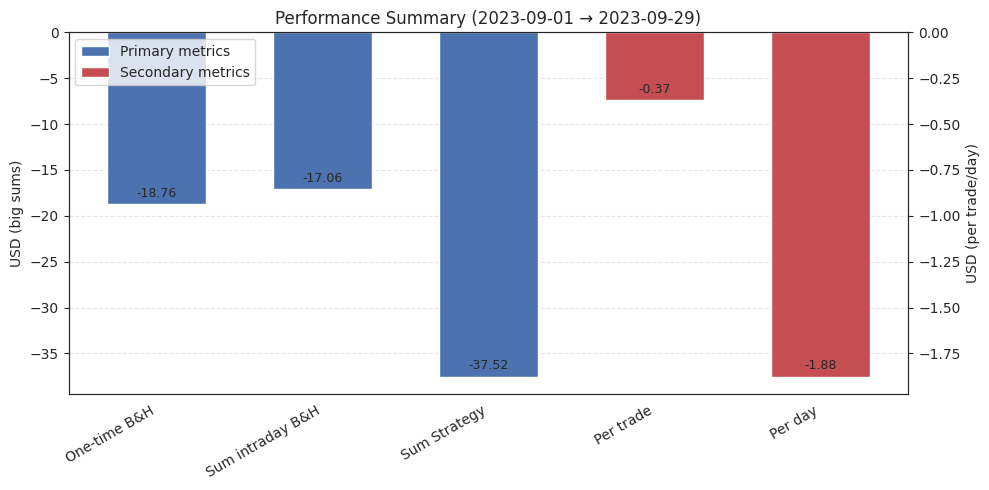


Overall Summary (2022-03-29 = 177.0727 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 19.320
Buy & Hold – each day ($): -192.076
Strategy Return ($): -1104.635
Trades Count: 4105
Strategy return per trade: -0.269
Num. trading days: 809
Strategy return per trading day: -1.365


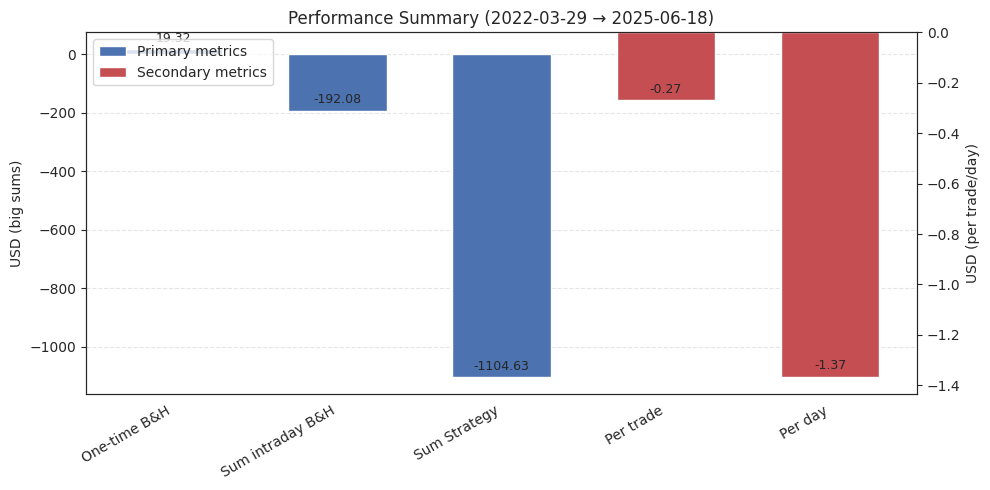

In [18]:
importlib.reload(plots) ############
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_check

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

feat_sel = df_feat_sel.columns.drop(['bid','ask','signal'])

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats,
            col_close         = 'close_mid',
            features          = feat_sel
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")
        print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)